In [1]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import random
import numpy as np
import random
import gym
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
from IPython.display import clear_output
import time
from tqdm import tqdm

### Setting Up the Environment


In [3]:
#Setting up the environment
env = gym.make("Taxi-v3")
env.reset()

#Current state
print(env.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
print("Primitive actions: ", action)
print("Options: ", ["OptionR", "OptionG", "OptionY", "OptionB"])
print("Total actions: ", action + ["OptionR", "OptionG", "OptionY", "OptionB"])

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.action_space.n)

# env.render()

7
Number of states: 500
Primitive actions:  ['south', 'north', 'east', 'west', 'pick', 'drop']
Options:  ['OptionR', 'OptionG', 'OptionY', 'OptionB']
Total actions:  ['south', 'north', 'east', 'west', 'pick', 'drop', 'OptionR', 'OptionG', 'OptionY', 'OptionB']
Number of actions that an agent can take: 6


### Epsilon Greedy Policy


In [4]:
def epgreedy_policy(q_values, state, epsilon):
    if q_values[state].any() and random.random() > epsilon:
        return np.argmax(q_values[state])
    
    else:
        return random.randint(0, q_values.shape[-1]-1)

In [5]:
#Number of options
num_options = 4

#Goal States' Coordinates
GOAL_STATES = {0: [0,0], 1: [0,4], 2: [4,0], 3:[4,3]}

#### Options Definition - (OptionR, OptionG, OptionY, OptionB)

In [6]:
def Options( env, state, Q, goalNum, eps = 0.1, goal = GOAL_STATES):
    optdone = False
    x, y, pas_loc, drop_loc = env.decode(state)
    if (x == goal[goalNum][0]  and y == goal[goalNum][1]):
        if pas_loc == goalNum:
            optact = 4
        elif drop_loc == goalNum:
            optact = 5
        else:
            optact = 1 if (goalNum in [0,1]) else 0
        
        optdone = True

    #If the goalNum is not one of the pas_loc or drop_loc
    else:
        state_num = 5*x + y
        optact = epgreedy_policy(Q[goalNum],  state_num, epsilon= eps)
    
    return [optact, optdone]

### SMDP Q-Learning Definition

In [7]:
ALPHA = 0.07
GAMMA = 0.9
EPS_MIN = 0.01
EPS_DECAY = 0.99
eps_main = 0.5
eps_options = {i:0.01 for i in range(num_options)}

NUM_X = 5
NUM_Y = 5
NUM_PAS_LOCS = 5
NUM_DROP_LOCS = 4

NUM_EPISODES = 1500

#Q-Table and Update-Frequencies
q_values_SMDP = np.zeros([NUM_PAS_LOCS*NUM_DROP_LOCS, num_options])
update_freq_SMDP = np.zeros([NUM_PAS_LOCS*NUM_DROP_LOCS, num_options])

#Q-values for each option

QoptSMDP = {i:np.zeros((env.observation_space.n//20, env.action_space.n-2)) for i in range(num_options)}



In [8]:
def smdpQlearning(env, num_episodes = NUM_EPISODES, gamma = GAMMA, alpha = ALPHA, eps_main = eps_main,eps_options = eps_options):
    total_episodic_rewards_smdp = []
    count = 0
    for i in tqdm(range(num_episodes)):
        # state = env.reset()[0]
        state=env.reset()
        done = False
        total_reward = 0
        T=1
        while not done:

            #choose action
            x,y,pas_loc, drop_loc = env.decode(state)

            subState = NUM_DROP_LOCS*pas_loc + drop_loc
            option = epgreedy_policy(q_values_SMDP, subState , epsilon = eps_main)
            eps_main = max(EPS_MIN, EPS_DECAY*eps_main)

            reward_bar = 0
            optdone = False
            move = 0
            starting_state = state

            while not optdone and not done:

                optact, optdone = Options(env, state, QoptSMDP, option, eps=eps_options[option])
                eps_options[option] = max(EPS_MIN, EPS_DECAY*eps_options[option])

                x,y,_,_ = env.decode(state); state_num = 5*x + y
                next_state, reward, done, _ = env.step(optact)

                #Render for last episode
                if i == num_episodes-1:
                    clear_output(wait=True)
                    print(env.render())  
                    time.sleep(T)
                
                x_next, y_next,_,_ = env.decode(next_state); next_state_num = 5*x_next + y_next

                reward_bar = gamma*reward + reward
                move +=1
                total_reward += reward
                reward_surr = reward

                if optdone:
                    reward_surr = 20
                if optact <4:
                    #Update Q-values for primitive actions in each option
                    QoptSMDP[option][state_num, optact] += alpha*(reward_surr + gamma*np.max(QoptSMDP[option][next_state_num]) - QoptSMDP[option][state_num, optact])

                state = next_state

            _,_,pas_loc, drop_loc = env.decode(state)
            subState = NUM_DROP_LOCS*pas_loc + drop_loc

            _,_,pas_loc, drop_loc = env.decode(starting_state)
            subStartState = NUM_DROP_LOCS*pas_loc + drop_loc

            #Update Q-values SMDP for each option
            q_values_SMDP[subStartState, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState,:]) - q_values_SMDP[subStartState, option])
            update_freq_SMDP[subStartState, option] +=1


        total_episodic_rewards_smdp.append(total_reward)
        x,y,pas_loc, drop_loc = env.decode(state)

        
        if pas_loc == drop_loc:
            count +=1
            clear_output(wait=True)
            
            print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

    return total_episodic_rewards_smdp

In [9]:
episodic_rewards_SMDP = smdpQlearning(env)

100%|██████████| 1500/1500 [00:22<00:00, 66.17it/s] 

Success (1482/1500) = 98.8%


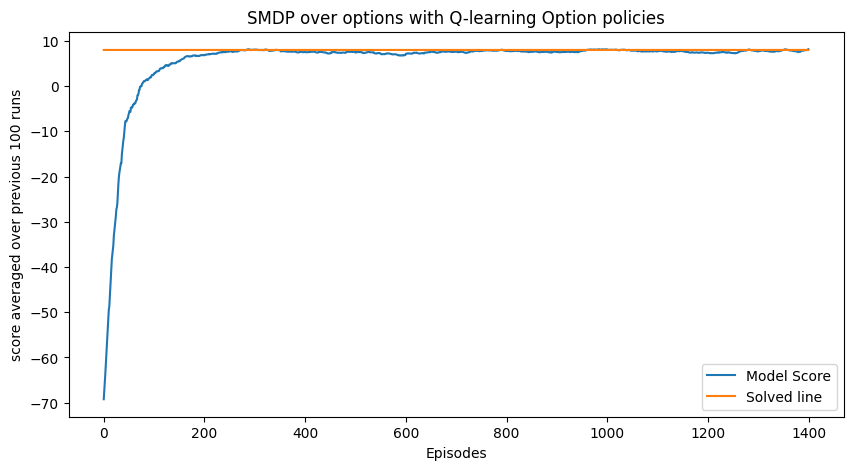

In [10]:
plt.figure(figsize = (10,5))
avg_rews2 = [np.average(episodic_rewards_SMDP[i:i+100]) for i in range(len(episodic_rewards_SMDP)-100)]
plt.plot(avg_rews2,label = 'Model Score')
plt.plot([8 for i in range(len(avg_rews2))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.legend()

## Intra Options Q Learning

In [11]:
ALPHA = 0.1
GAMMA = 0.9
EPS_MIN = 0.01
EPS_DECAY = 0.99
eps_main = 0.5
eps_options = {i:0.01 for i in range(num_options)}


#Q-Table and Update-Frequencies
q_values_IOQL = np.zeros([NUM_PAS_LOCS*NUM_DROP_LOCS, num_options])
update_freq_IOQL = np.zeros([NUM_PAS_LOCS*NUM_DROP_LOCS, num_options])


#Q-values for each option
QoptIOQL = {i:np.zeros((env.observation_space.n//20, env.action_space.n-2)) for i in range(num_options)}

In [12]:
def ReturnSubstate(state, nPas = NUM_PAS_LOCS, nDrop = NUM_DROP_LOCS):
  _,_,pas,drop = env.decode(state) 
  subState = nDrop*pas+drop 
  return subState 

In [13]:

def IntraOpt(env, num_episodes = NUM_EPISODES, gamma = GAMMA, alpha = ALPHA, eps_main = eps_main,eps_options = eps_options):

  total_episodic_rewards_ioql = []
  count=0
  T=1
  # Iterate over Number of Episodes
  for i in range(NUM_EPISODES):
      state = env.reset()    
      done = False
      tot_rew=0

      # While episode is not over
      while not done:
          
          # Choose action  
          _,_,pas,drop = env.decode(state) 
          
          subState = NUM_DROP_LOCS*pas+drop      
          option = epgreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
          eps_main = max(EPS_MIN,EPS_DECAY*eps_main)
          optdone = False
          prev = state  

          while not optdone and not done:
              
              optact,optdone = Options(env,state,QoptIOQL,option,eps_options[option])
              eps_options[option] = max(EPS_MIN,EPS_DECAY*eps_options[option])
              next_state, reward, done,_ = env.step(optact)
              tot_rew+=reward

              
              #Option Policy Learning
              [x,y,_,_]=  list(env.decode(state)) 
              [x1,y1,_,_]=  list(env.decode(next_state)) 
              reward_surr = reward

              if optdone:
                reward_surr = 20
              if optact<4:  
                QoptIOQL[option][5*x+y, optact] = QoptIOQL[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(QoptIOQL[option][5*x1+y1, :]) - QoptIOQL[option][5*x+y, optact])

              #finding all options giving same action call
              
              for same_action_options in range(num_options):
                optact_o,optdone_o = Options(env,state,QoptIOQL,same_action_options,eps_options[same_action_options])
                if optact_o == optact:
                  eps_options[same_action_options] = max(EPS_MIN,EPS_DECAY*eps_options[same_action_options])
                  if optdone_o:
                    q_values_IOQL[ReturnSubstate(state), same_action_options] += alpha*(reward + gamma*np.max(q_values_IOQL[ReturnSubstate(next_state), :]) - q_values_IOQL[ReturnSubstate(state), same_action_options])

                  else:
                    q_values_IOQL[ReturnSubstate(state), same_action_options] += alpha*(reward + gamma*q_values_IOQL[ReturnSubstate(next_state), same_action_options] - q_values_IOQL[ReturnSubstate(state), same_action_options]) 

                  update_freq_IOQL[ReturnSubstate(state), same_action_options] += 1

              state = next_state 

              #Render only in the last episode
              if i==NUM_EPISODES-1:
                  clear_output(wait=True)
                  print(env.render())
                  time.sleep(T)

      total_episodic_rewards_ioql.append(tot_rew)
      x,y,pas,drop = env.decode(state)
      if pas==drop:
        count+=1
        clear_output(wait=True)
        print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))

  return total_episodic_rewards_ioql
      

In [14]:
episodic_rewards_IOQL = IntraOpt(env)

Success (1477/1500) = 98.46666666666667%


#### Plot comparing the reward curves

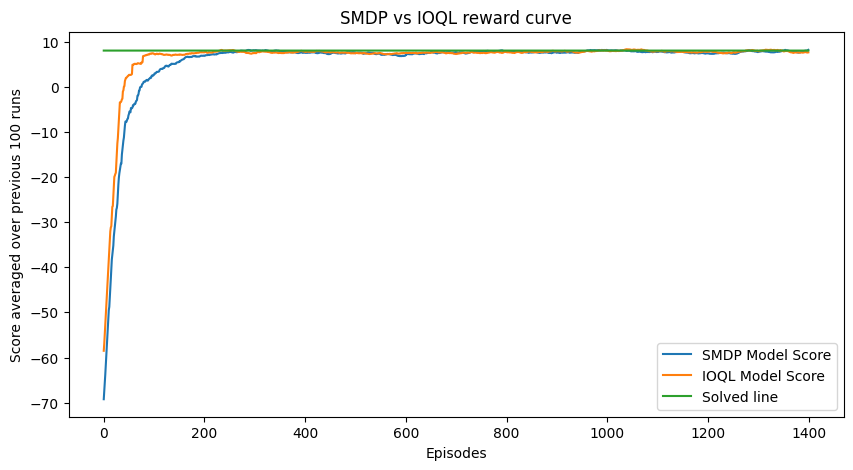

In [15]:
import matplotlib.pyplot as plt

# Assuming episodic_rewards_SMDP and episodic_rewards_IOQL are lists containing episodic rewards for SMDP and IOQL respectively

plt.figure(figsize=(10, 5))

# Calculate average rewards over a window of 100 episodes for both SMDP and IOQL
avg_rews_SMDP = [np.average(episodic_rewards_SMDP[i:i+100]) for i in range(len(episodic_rewards_SMDP)-100)]
avg_rews_IOQL = [np.average(episodic_rewards_IOQL[i:i+100]) for i in range(len(episodic_rewards_IOQL)-100)]

# Plot average rewards
plt.plot(avg_rews_SMDP, label='SMDP Model Score')
plt.plot(avg_rews_IOQL, label='IOQL Model Score')
solved_score = env.spec.reward_threshold
plt.plot([solved_score for _ in range(len(avg_rews_SMDP))], label='Solved line')

plt.xlabel('Episodes')
plt.ylabel('Score averaged over previous 100 runs')
plt.title('SMDP vs IOQL reward curve')
plt.legend()

plt.show()


#### Plot comparing the reward curves for first and last 300 episodes

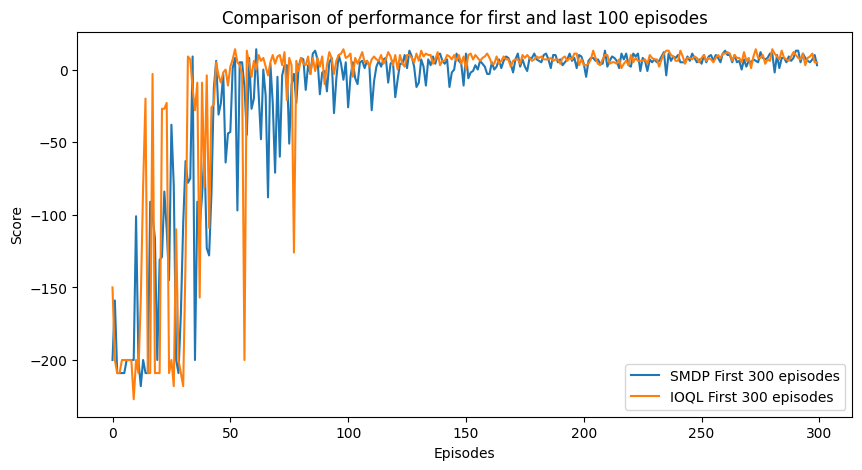

In [16]:
import matplotlib.pyplot as plt

# Assuming episodic_rewards_SMDP and episodic_rewards_IOQL are lists containing episodic rewards for SMDP and IOQL respectively
plt.figure(figsize=(10, 5))

# Plot episodic rewards for the first 300 episodes
plt.plot(episodic_rewards_SMDP[:300], label='SMDP First 300 episodes')
plt.plot(episodic_rewards_IOQL[:300], label='IOQL First 300 episodes')

plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Comparison of performance for first and last 100 episodes')
plt.legend()

plt.show()


#### Plot comparing the moving avg reward (window-size = 100 episodes) curves for first 300 episodes

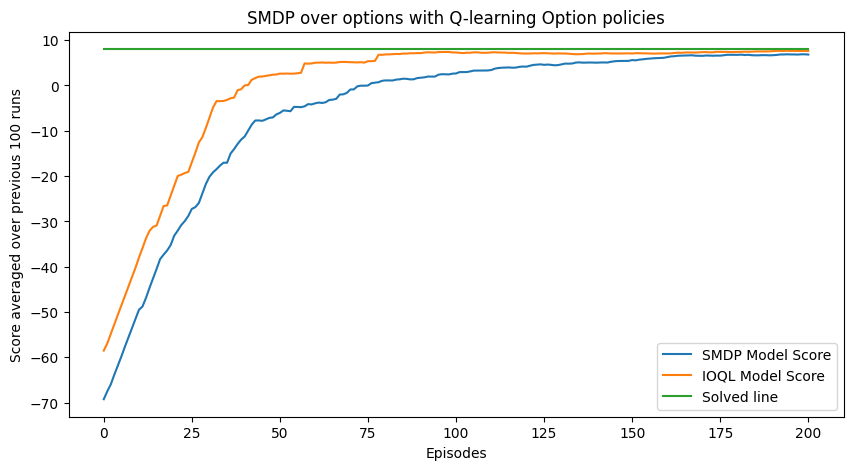

In [17]:
import matplotlib.pyplot as plt

# Assuming episodic_rewards_SMDP and episodic_rewards_IOQL are lists containing episodic rewards for SMDP and IOQL respectively

plt.figure(figsize=(10, 5))

# Calculate average rewards over a window of 100 episodes for both SMDP and IOQL
avg_rews_SMDP = [np.average(episodic_rewards_SMDP[i:i+100]) for i in range(300+1-100)]
avg_rews_IOQL = [np.average(episodic_rewards_IOQL[i:i+100]) for i in range(300+1-100)]

# Plot average rewards
plt.plot(avg_rews_SMDP, label='SMDP Model Score')
plt.plot(avg_rews_IOQL, label='IOQL Model Score')
solved_score = env.spec.reward_threshold
plt.plot([solved_score for _ in range(len(avg_rews_SMDP))], label='Solved line')

plt.xlabel('Episodes')
plt.ylabel('Score averaged over previous 100 runs')
plt.title('SMDP over options with Q-learning Option policies')
plt.legend()

plt.show()


#### Plot comparing the moving avg reward (window size = 100 episodes) curves for last 300 episodes

C:\Users\shivp\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\shivp\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


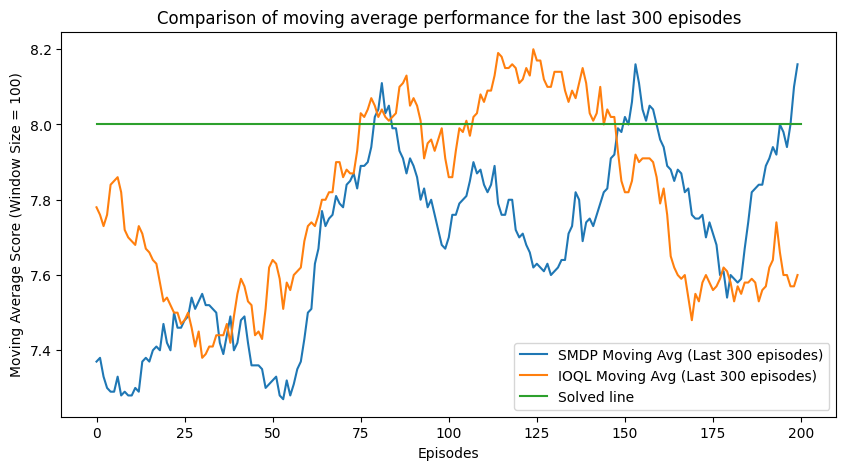

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming episodic_rewards_SMDP and episodic_rewards_IOQL are lists containing episodic rewards for SMDP and IOQL respectively

plt.figure(figsize=(10, 5))
nlast=300
# Calculate moving average for the last 300 episodes for both SMDP and IOQL
window_size = 100
moving_avg_SMDP_last = [np.mean(episodic_rewards_SMDP[-nlast + i:-nlast + i + window_size]) for i in range(nlast - window_size + 1)]
moving_avg_IOQL_last = [np.mean(episodic_rewards_IOQL[-nlast + i:-nlast + i + window_size]) for i in range(nlast - window_size + 1)]

# Plot moving average for the last 300 episodes
plt.plot(moving_avg_SMDP_last, label='SMDP Moving Avg (Last 300 episodes)')
plt.plot(moving_avg_IOQL_last, label='IOQL Moving Avg (Last 300 episodes)')
solved_score = env.spec.reward_threshold
plt.plot([solved_score for _ in range(len(avg_rews_SMDP))], label='Solved line')

plt.xlabel('Episodes')
plt.ylabel('Moving Average Score (Window Size = 100)')
plt.title('Comparison of moving average performance for the last 300 episodes')
plt.legend()

plt.show()


### Policy learnt by SMDP

Text(0.5, 1.0, 'Policy learnt by SMDP')

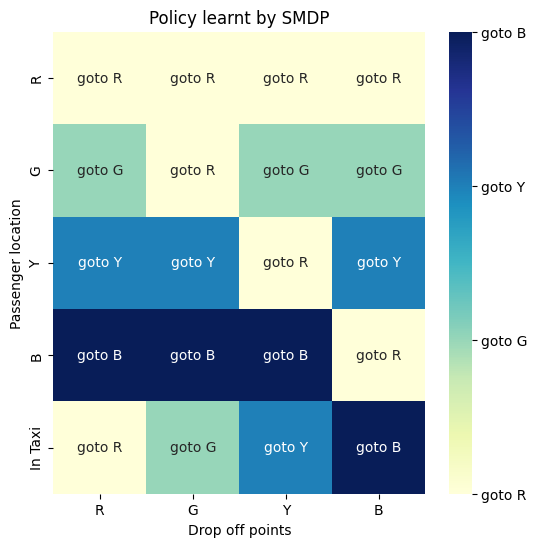

In [19]:
import matplotlib as mpl
Qmax_SMDP = np.argmax(q_values_SMDP,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(6,6))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','In Taxi'],annot = annot_text,fmt = '', cmap  = mpl.colormaps['YlGnBu'])
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy learnt by SMDP')

### Policy learnt by IOQL

Text(0.5, 1.0, 'Policy learnt by IOQL')

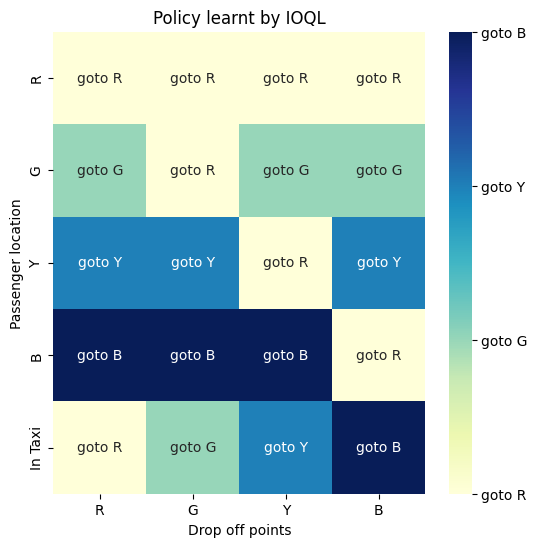

In [20]:
import matplotlib as mpl
Qmax_IOQL = np.argmax(q_values_IOQL,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(6,6))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','In Taxi'],annot = annot_text,fmt = '', cmap  = mpl.colormaps['YlGnBu'])
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy learnt by IOQL')

### Learnt policy for each option for SMDP

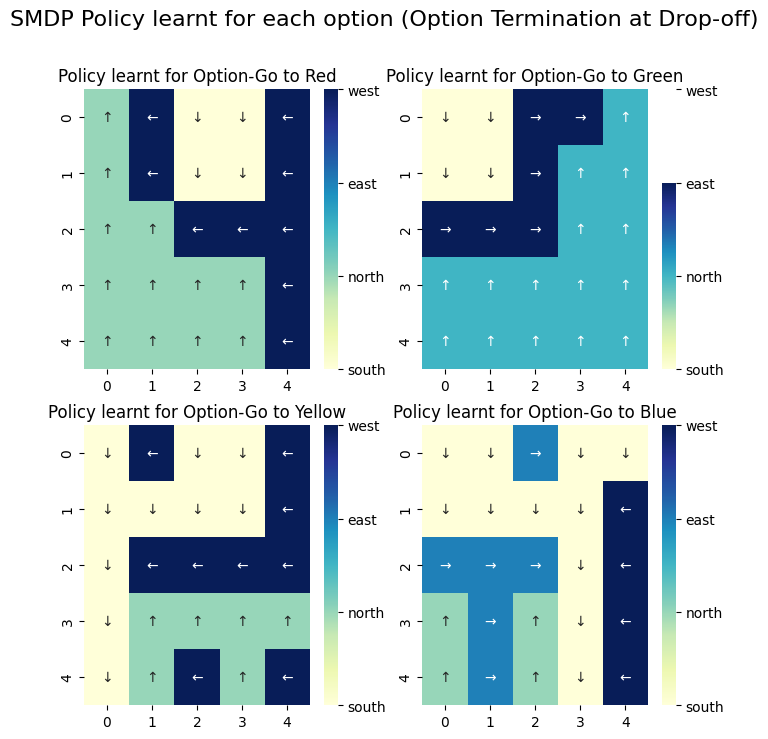

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define Unicode characters for arrows
arrow_labels = {0: '↓', 1: '↑', 2: '→', 3: '←'}  # Unicode arrows for south, north, east, west, pickup, drop respectively
option_names = ['Go to Red', 'Go to Green', 'Go to Yellow', 'Go to Blue']
# Assuming Qopt is your Q-values matrix for each option
# Assuming Qopt has the shape (num_options, num_states, num_actions)

# Create the heatmap
figure, axis = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        # Get the action with the highest Q-value for each state
        actions = np.argmax(QoptSMDP[2*i+j], axis=1)
        
        # Create annotation text based on arrow labels
        annot_text = np.vectorize(arrow_labels.get)(actions.reshape(5, 5))
        
        # Create heatmap
        ax = sns.heatmap(actions.reshape(5, 5), ax=axis[i,j], annot=annot_text, fmt='', cmap='YlGnBu')
        # axis[i,j].set_title("Policy learnt){}".format(i*2+j))
        axis[i,j].set_title("Policy learnt for Option-{}".format(option_names[i*2+j]))
        plt.suptitle("SMDP Policy learnt for each option (Option Termination at Drop-off)", fontsize=16)
        
        # Customize colorbar
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i for i in range(4)])
        c_bar.set_ticklabels(['south', 'north', 'east', 'west'])

plt.show()


### Learnt policy for each option for IOQL

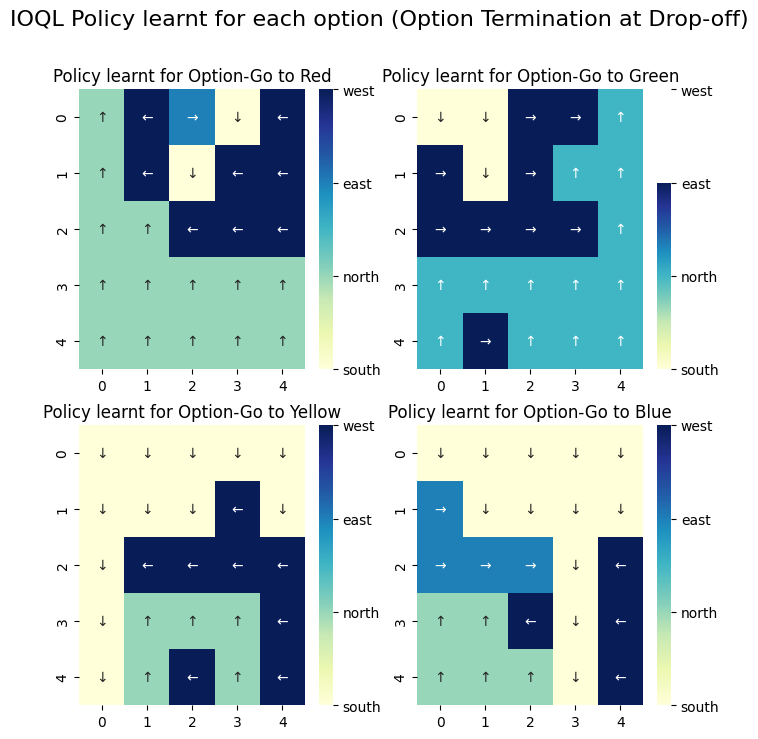

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define Unicode characters for arrows
arrow_labels = {0: '↓', 1: '↑', 2: '→', 3: '←'}  # Unicode arrows for south, north, east, west, pickup, drop respectively
option_names = ['Go to Red', 'Go to Green', 'Go to Yellow', 'Go to Blue']
# Assuming Qopt is your Q-values matrix for each option
# Assuming Qopt has the shape (num_options, num_states, num_actions)

# Create the heatmap
figure, axis = plt.subplots(2, 2, figsize=(8, 8))
for i in range(2):
    for j in range(2):
        # Get the action with the highest Q-value for each state
        actions = np.argmax(QoptIOQL[2*i+j], axis=1)
        
        # Create annotation text based on arrow labels
        annot_text = np.vectorize(arrow_labels.get)(actions.reshape(5, 5))
        
        # Create heatmap
        ax = sns.heatmap(actions.reshape(5, 5), ax=axis[i,j], annot=annot_text, fmt='', cmap='YlGnBu')
        axis[i,j].set_title("Policy learnt) {}".format(i*2+j))
        axis[i,j].set_title("Policy learnt for Option-{}".format(option_names[i*2+j]))
        plt.suptitle("IOQL Policy learnt for each option (Option Termination at Drop-off)", fontsize=16)

        # Customize colorbar
        c_bar = ax.collections[0].colorbar
        c_bar.set_ticks([i for i in range(4)])
        c_bar.set_ticklabels(['south', 'north', 'east', 'west'])

plt.show()


### Visualising the update frequency table

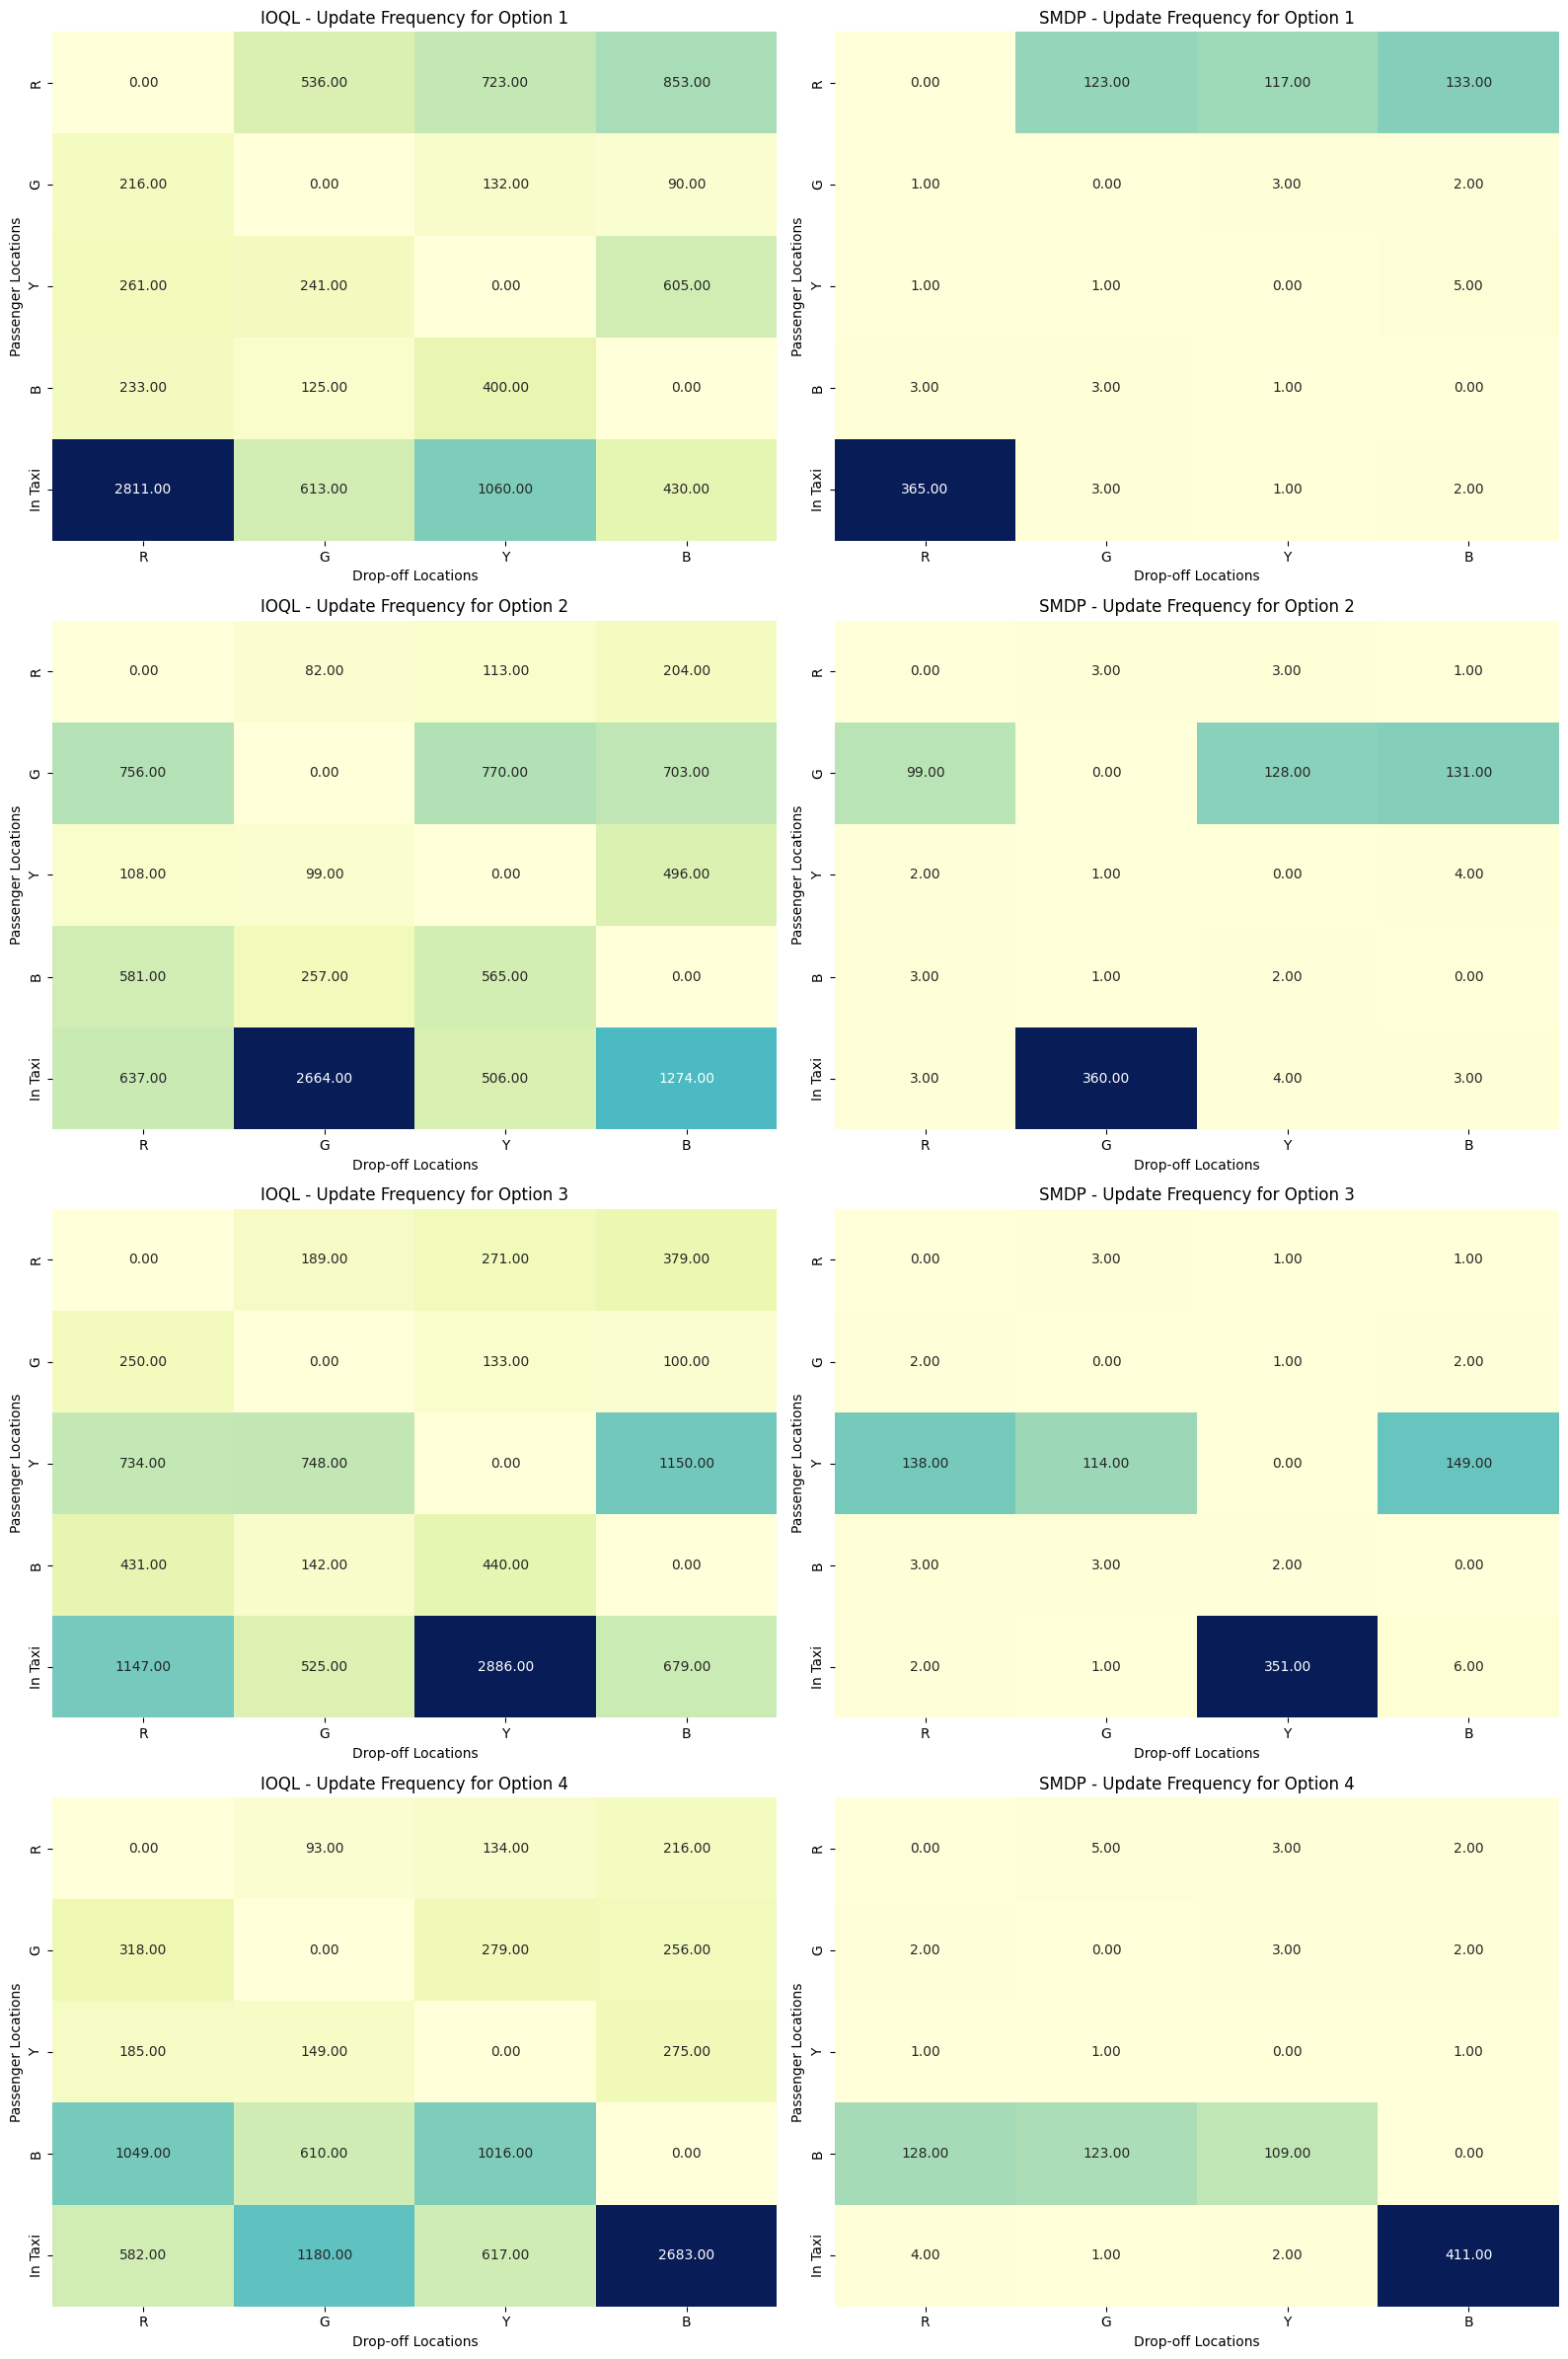

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming update_freq_IOQL and update_freq_SMDP are your update frequency tables for IOQL and SMDP respectively

# Define constants
NUM_PAS_LOCS = 5  # Number of passenger locations
NUM_DROP_LOCS = 4  # Number of drop-off locations
num_options = 4  # Number of options

# Reshape update frequency tables to [NUM_PAS_LOCS, NUM_DROP_LOCS, num_options]
update_freq_IOQL_reshaped = update_freq_IOQL.reshape(NUM_PAS_LOCS, NUM_DROP_LOCS, num_options)
update_freq_SMDP_reshaped = update_freq_SMDP.reshape(NUM_PAS_LOCS, NUM_DROP_LOCS, num_options)

# Create a list of options
options = [f'Option {i+1}' for i in range(num_options)]

# Define labels for passenger and drop-off locations
passenger_locations = ["R", "G", "Y", "B", "In Taxi"]
drop_off_points = ["R", "G", "Y", "B"]

# Create figure and subplots
fig, axes = plt.subplots(num_options, 2, figsize=(16, 24))

# Iterate over each option for both IOQL and SMDP
for option_index, option in enumerate(options):
    # Get update frequency for the current option for IOQL and SMDP
    update_freq_IOQL_option = update_freq_IOQL_reshaped[:, :, option_index]
    update_freq_SMDP_option = update_freq_SMDP_reshaped[:, :, option_index]
    
    # Plot update frequency heatmap for the current option for IOQL
    sns.heatmap(update_freq_IOQL_option, ax=axes[option_index, 0], annot=True, fmt='.2f', cmap="YlGnBu",
                xticklabels=drop_off_points, yticklabels=passenger_locations, cbar=False)
    axes[option_index, 0].set_title(f'IOQL - Update Frequency for {option}')
    axes[option_index, 0].set_xlabel('Drop-off Locations')
    axes[option_index, 0].set_ylabel('Passenger Locations')
    
    # Plot update frequency heatmap for the current option for SMDP
    sns.heatmap(update_freq_SMDP_option, ax=axes[option_index, 1], annot=True, fmt='.2f', cmap="YlGnBu",
                xticklabels=drop_off_points, yticklabels=passenger_locations, cbar=False)
    axes[option_index, 1].set_title(f'SMDP - Update Frequency for {option}')
    axes[option_index, 1].set_xlabel('Drop-off Locations')
    axes[option_index, 1].set_ylabel('Passenger Locations')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
